Analyzing 5001 frames...

【区間別遅延解析結果】
 Section         | Mean       | Median     | Max        | StdDev    
--------------------------------------------------------------------------------
 Wi-Fi           | 0.8126 s   | 0.7468 s   | 2.7384 s   | 0.3783 s
 Wired           | 0.0181 s   | 0.0170 s   | 0.0884 s   | 0.0108 s
 Render          | 0.0119 s   | 0.0078 s   | 0.0944 s   | 0.0108 s
 Total E2E       | 0.8426 s   | 0.7780 s   | 2.7628 s   | 0.3817 s


/tmp/ipykernel_120054/2467049783.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax4.boxplot(datasets, labels=labels, patch_artist=True, showfliers=False)



グラフを保存しました: latency_dashboard.png


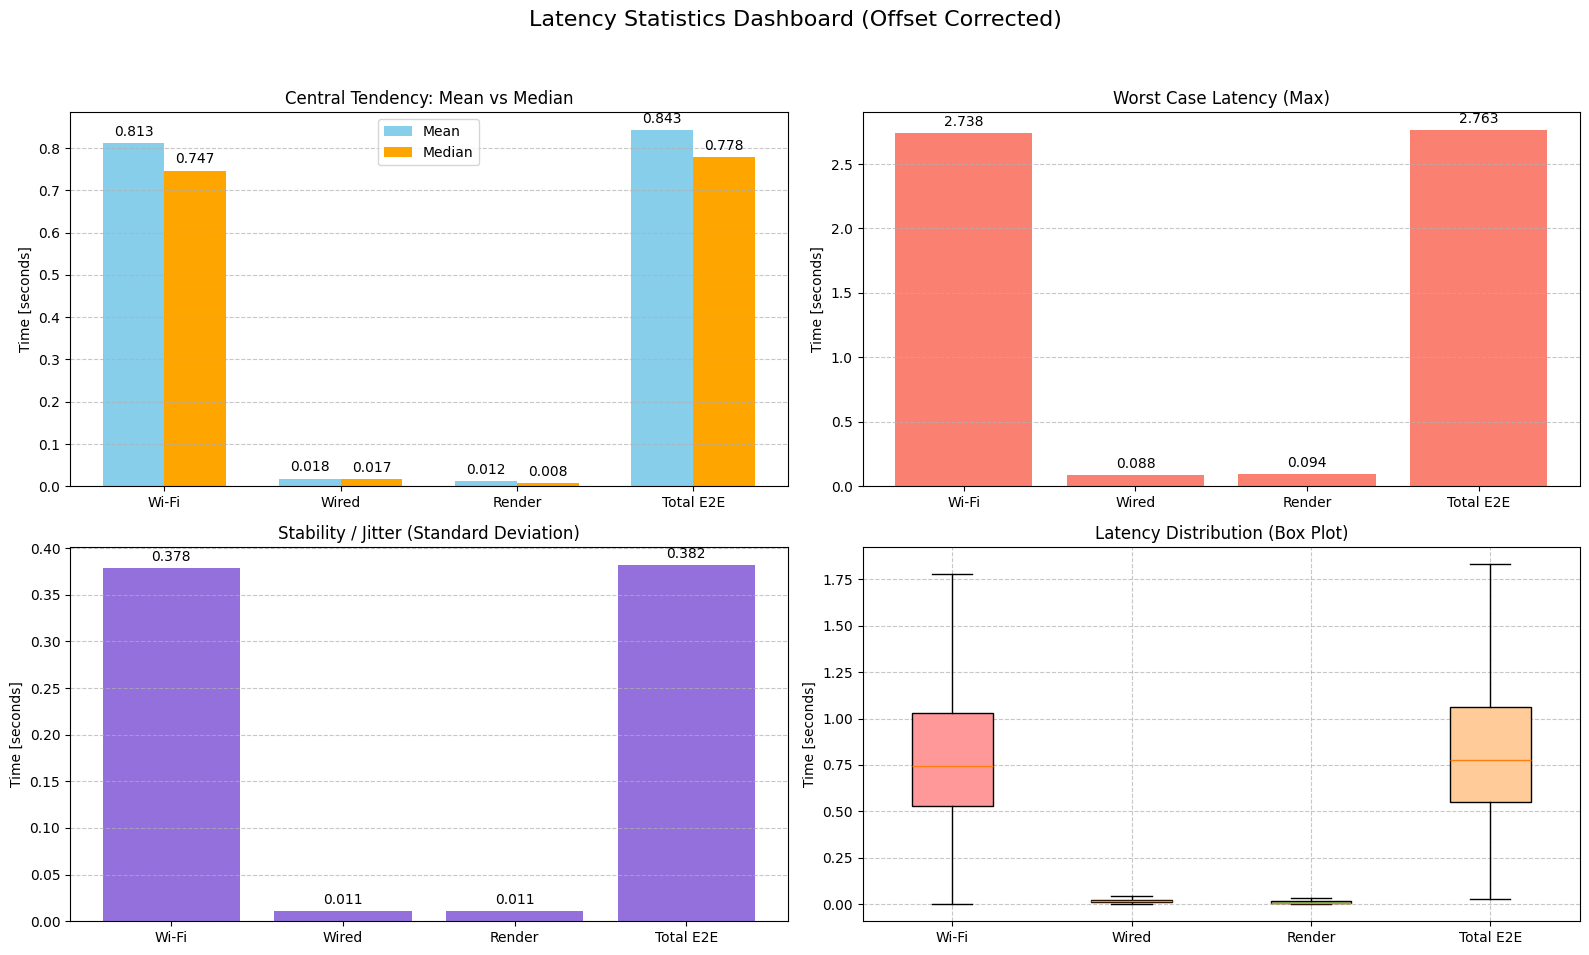

In [1]:
import csv
import statistics
import matplotlib.pyplot as plt
import numpy as np

# --- ファイル名 ---
FILE_UBUNTU  = 'ubuntu_e2elog_20251211_154901417.csv'
FILE_WINDOWS = 'unity_udplog_20251211_154903.csv'
FILE_UNITY   = 'unity_e2elog_20251211_154903.csv'

def read_csv(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return list(csv.reader(f))
    except:
        return []

def main():
    u_lines = read_csv(FILE_UBUNTU)
    w_lines = read_csv(FILE_WINDOWS)
    r_lines = read_csv(FILE_UNITY)

    if not (u_lines and w_lines and r_lines): return

    min_len = min(len(u_lines), len(w_lines), len(r_lines))
    print(f"Analyzing {min_len} frames...")

    # 生の時刻データリスト
    raw_t0, raw_t1, raw_t2, raw_t3 = [], [], [], []

    for i in range(1, min_len):
        try:
            t0 = float(u_lines[i][1]) * 1.0e-9 
            t1 = float(u_lines[i][4])          
            t2 = float(w_lines[i][1])          
            t3 = float(r_lines[i][1])          
            
            raw_t0.append(t0)
            raw_t1.append(t1)
            raw_t2.append(t2)
            raw_t3.append(t3)
        except:
            continue

    # --- 区間ごとの差分計算 ---
    diff_wifi = [t1 - t0 for t1, t0 in zip(raw_t1, raw_t0)]
    diff_wired = [t2 - t1 for t2, t1 in zip(raw_t2, raw_t1)]
    diff_render = [t3 - t2 for t3, t2 in zip(raw_t3, raw_t2)]

    # --- オフセット除去 (最小値基準) ---
    min_wifi = min(diff_wifi)
    min_wired = min(diff_wired)
    min_render = min(diff_render)

    # 補正後の遅延リスト
    corr_wifi   = [d - min_wifi for d in diff_wifi]
    corr_wired  = [d - min_wired for d in diff_wired]
    corr_render = [d - min_render for d in diff_render]
    
    # 積み上げ合計 (Total E2E)
    corr_total = [a + b + c for a, b, c in zip(corr_wifi, corr_wired, corr_render)]

    # --- 統計量の計算 ---
    # リストにまとめて処理しやすくします
    datasets = [corr_wifi, corr_wired, corr_render, corr_total]
    labels = ['Wi-Fi', 'Wired', 'Render', 'Total E2E']
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'] # 赤, 青, 緑, 橙

    stats_mean = [statistics.mean(d) for d in datasets]
    stats_median = [statistics.median(d) for d in datasets]
    stats_max = [max(d) for d in datasets]
    stats_std = [statistics.stdev(d) for d in datasets]
    # stats_min は理論上すべて 0.0 なのでグラフ化は省略します

    # コンソール出力
    print("\n【区間別遅延解析結果】")
    print("=" * 80)
    print(f" {'Section':<15} | {'Mean':<10} | {'Median':<10} | {'Max':<10} | {'StdDev':<10}")
    print("-" * 80)
    for i in range(4):
        print(f" {labels[i]:<15} | {stats_mean[i]:.4f} s   | {stats_median[i]:.4f} s   | {stats_max[i]:.4f} s   | {stats_std[i]:.4f} s")
    print("=" * 80)


    # --- グラフ描画 (ダッシュボード形式) ---
    # 2行2列のレイアウトを作成
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Latency Statistics Dashboard (Offset Corrected)', fontsize=16)

    # -------------------------------------------------------
    # 1. 左上: 平均値(Mean) と 中央値(Median) の比較
    # -------------------------------------------------------
    ax1 = axes[0, 0]
    x = np.arange(len(labels))
    width = 0.35

    rects1 = ax1.bar(x - width/2, stats_mean, width, label='Mean', color='skyblue')
    rects2 = ax1.bar(x + width/2, stats_median, width, label='Median', color='orange')

    ax1.set_title('Central Tendency: Mean vs Median')
    ax1.set_ylabel('Time [seconds]')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 値をバーの上に表示
    ax1.bar_label(rects1, padding=3, fmt='%.3f')
    ax1.bar_label(rects2, padding=3, fmt='%.3f')


    # -------------------------------------------------------
    # 2. 右上: 最大遅延 (Max Latency - Worst Case)
    # -------------------------------------------------------
    ax2 = axes[0, 1]
    rects3 = ax2.bar(labels, stats_max, color='salmon')
    
    ax2.set_title('Worst Case Latency (Max)')
    ax2.set_ylabel('Time [seconds]')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.bar_label(rects3, padding=3, fmt='%.3f')


    # -------------------------------------------------------
    # 3. 左下: 標準偏差 (Standard Deviation - Jitter)
    # -------------------------------------------------------
    ax3 = axes[1, 0]
    rects4 = ax3.bar(labels, stats_std, color='mediumpurple')

    ax3.set_title('Stability / Jitter (Standard Deviation)')
    ax3.set_ylabel('Time [seconds]')
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    ax3.bar_label(rects4, padding=3, fmt='%.3f')


    # -------------------------------------------------------
    # 4. 右下: 箱ひげ図 (Distribution) - 全体の分布
    # -------------------------------------------------------
    ax4 = axes[1, 1]
    bplot = ax4.boxplot(datasets, labels=labels, patch_artist=True, showfliers=False)
    
    # 箱の色を設定
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax4.set_title('Latency Distribution (Box Plot)')
    ax4.set_ylabel('Time [seconds]')
    ax4.grid(True, linestyle='--', alpha=0.7)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # タイトル分のスペースを空ける
    
    save_filename = 'latency_dashboard.png'
    plt.savefig(save_filename)
    print(f"\nグラフを保存しました: {save_filename}")
    plt.show()

if __name__ == "__main__":
    main()

Plotting 5001 frames... (This might take a moment)

グラフを保存しました: latency_timeseries_all.png


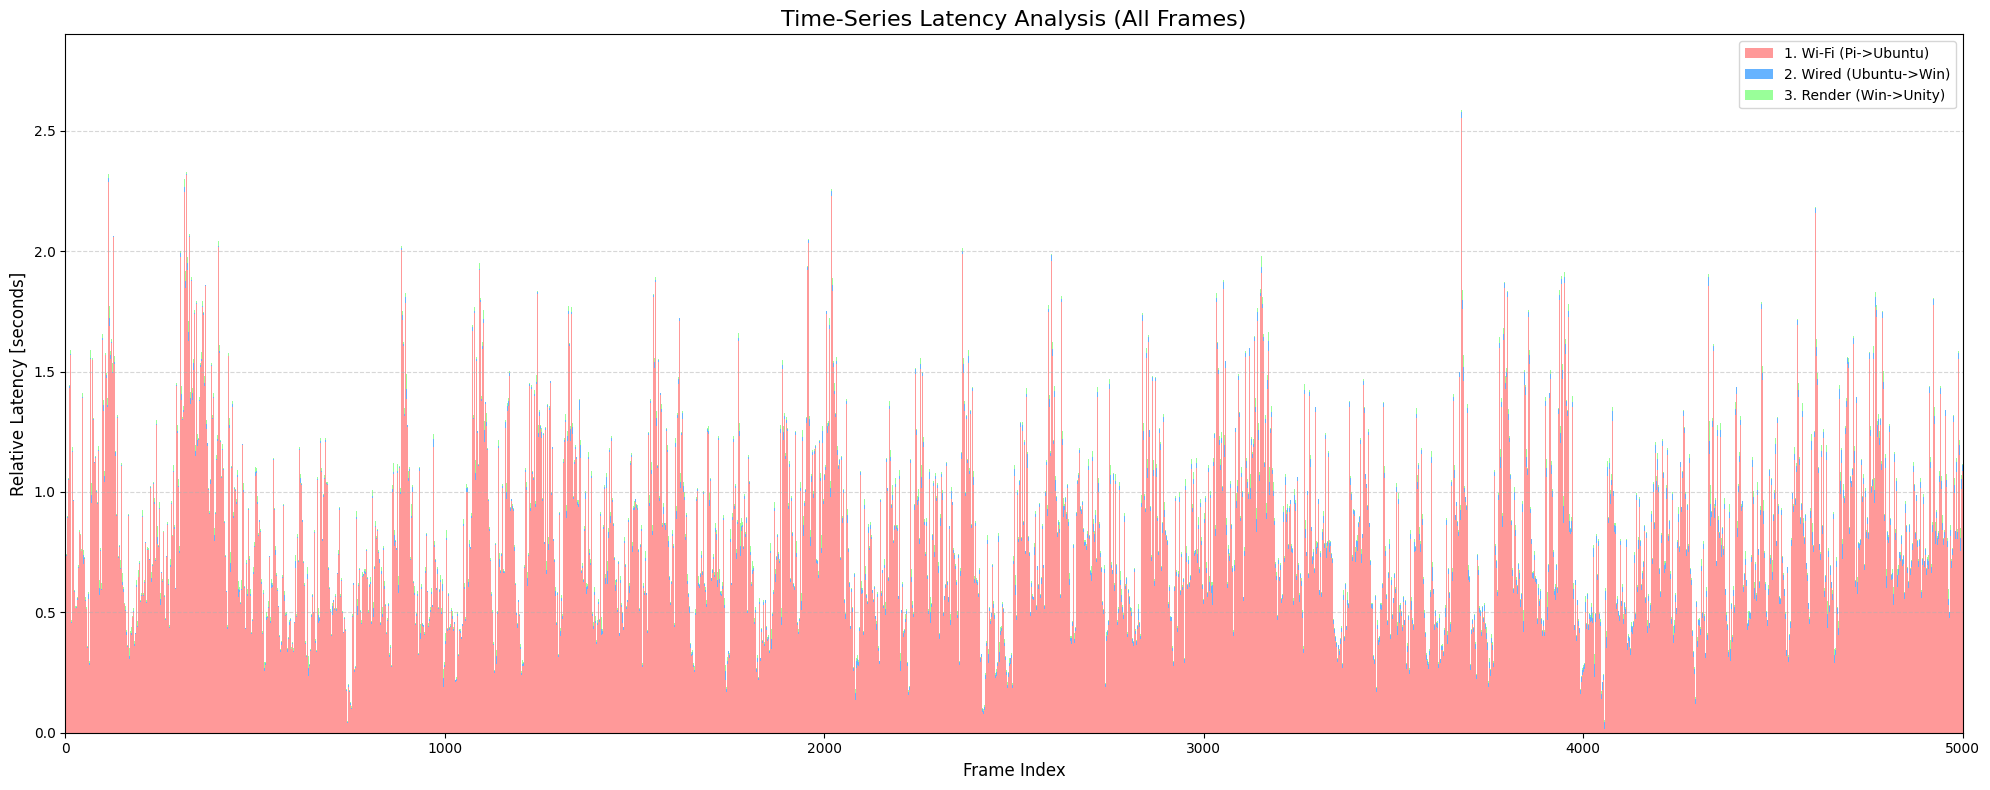

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np

# --- ファイル名 ---
FILE_UBUNTU  = 'ubuntu_e2elog_20251211_154901417.csv'
FILE_WINDOWS = 'unity_udplog_20251211_154903.csv'
FILE_UNITY   = 'unity_e2elog_20251211_154903.csv'

def read_csv(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return list(csv.reader(f))
    except:
        return []

def main():
    u_lines = read_csv(FILE_UBUNTU)
    w_lines = read_csv(FILE_WINDOWS)
    r_lines = read_csv(FILE_UNITY)

    if not (u_lines and w_lines and r_lines): return

    min_len = min(len(u_lines), len(w_lines), len(r_lines))
    print(f"Plotting {min_len} frames... (This might take a moment)")

    # Numpy配列を使うと計算が速いので変換します
    t0_list, t1_list, t2_list, t3_list = [], [], [], []

    for i in range(1, min_len):
        try:
            t0_list.append(float(u_lines[i][1]) * 1.0e-9) # LiDAR生成
            t1_list.append(float(u_lines[i][4]))          # Ubuntu受信
            t2_list.append(float(w_lines[i][1]))          # Win受信
            t3_list.append(float(r_lines[i][1]))          # Unity描画
        except:
            continue

    # numpy配列に変換
    np_t0 = np.array(t0_list)
    np_t1 = np.array(t1_list)
    np_t2 = np.array(t2_list)
    np_t3 = np.array(t3_list)

    # --- 区間ごとの差分計算 ---
    diff_wifi   = np_t1 - np_t0 # Wi-Fi
    diff_wired  = np_t2 - np_t1 # 有線
    diff_render = np_t3 - np_t2 # 描画

    # --- オフセット除去 (最小値を0にする) ---
    # これにより時計ズレを排除し、遅延の「量」だけを残します
    corr_wifi   = diff_wifi - np.min(diff_wifi)
    corr_wired  = diff_wired - np.min(diff_wired)
    corr_render = diff_render - np.min(diff_render)

    # --- グラフ描画 (5000本の積み上げ棒グラフ) ---
    fig, ax = plt.subplots(figsize=(20, 8)) # 横長にします

    # フレーム番号 (X軸)
    indices = np.arange(len(corr_wifi))
    
    # 棒の太さ (1.0だと隙間なし)
    bar_width = 1.0 

    # 1. Wi-Fi区間 (一番下: 赤)
    p1 = ax.bar(indices, corr_wifi, bar_width, label='1. Wi-Fi (Pi->Ubuntu)', color='#ff9999', align='edge')

    # 2. 有線区間 (真ん中: 青) - Wi-Fiの上に積む
    p2 = ax.bar(indices, corr_wired, bar_width, bottom=corr_wifi, label='2. Wired (Ubuntu->Win)', color='#66b3ff', align='edge')

    # 3. 描画区間 (一番上: 緑) - Wi-Fi + 有線の上に積む
    p3 = ax.bar(indices, corr_render, bar_width, bottom=corr_wifi+corr_wired, label='3. Render (Win->Unity)', color='#99ff99', align='edge')

    # 装飾
    ax.set_title('Time-Series Latency Analysis (All Frames)', fontsize=16)
    ax.set_xlabel('Frame Index', fontsize=12)
    ax.set_ylabel('Relative Latency [seconds]', fontsize=12)
    ax.set_xlim(0, len(indices)) # X軸の範囲をデータ数に合わせる
    ax.legend(loc='upper right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 保存と表示
    filename = 'latency_timeseries_all.png'
    plt.tight_layout()
    plt.savefig(filename, dpi=150) # 解像度高めで保存
    print(f"\nグラフを保存しました: {filename}")
    plt.show()

if __name__ == "__main__":
    main()

Analysis for 5001 frames...
【Wi-Fi】 Avg: 0.81313s, Max: 2.72317s, Std: 0.37814s
【Wired Raw】 Avg: 0.01812s, Max: 0.08838s, Std: 0.01077s
【Wired Detrended】 Avg: 0.00759s, Max: 0.06934s, Std: 0.00844s
【Render】Avg: 0.01194s, Max: 0.09441s, Std: 0.01078s
【Total】 Avg: 0.83266s, Max: 2.74714s, Std: 0.38168s
時系列グラフを保存しました: latency_timeseries.png

Generating Box Plot...


/tmp/ipykernel_120054/1722027826.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax_box.boxplot(data_box, labels=labels_box, patch_artist=True,


箱ひげ図を保存しました: latency_boxplot.png


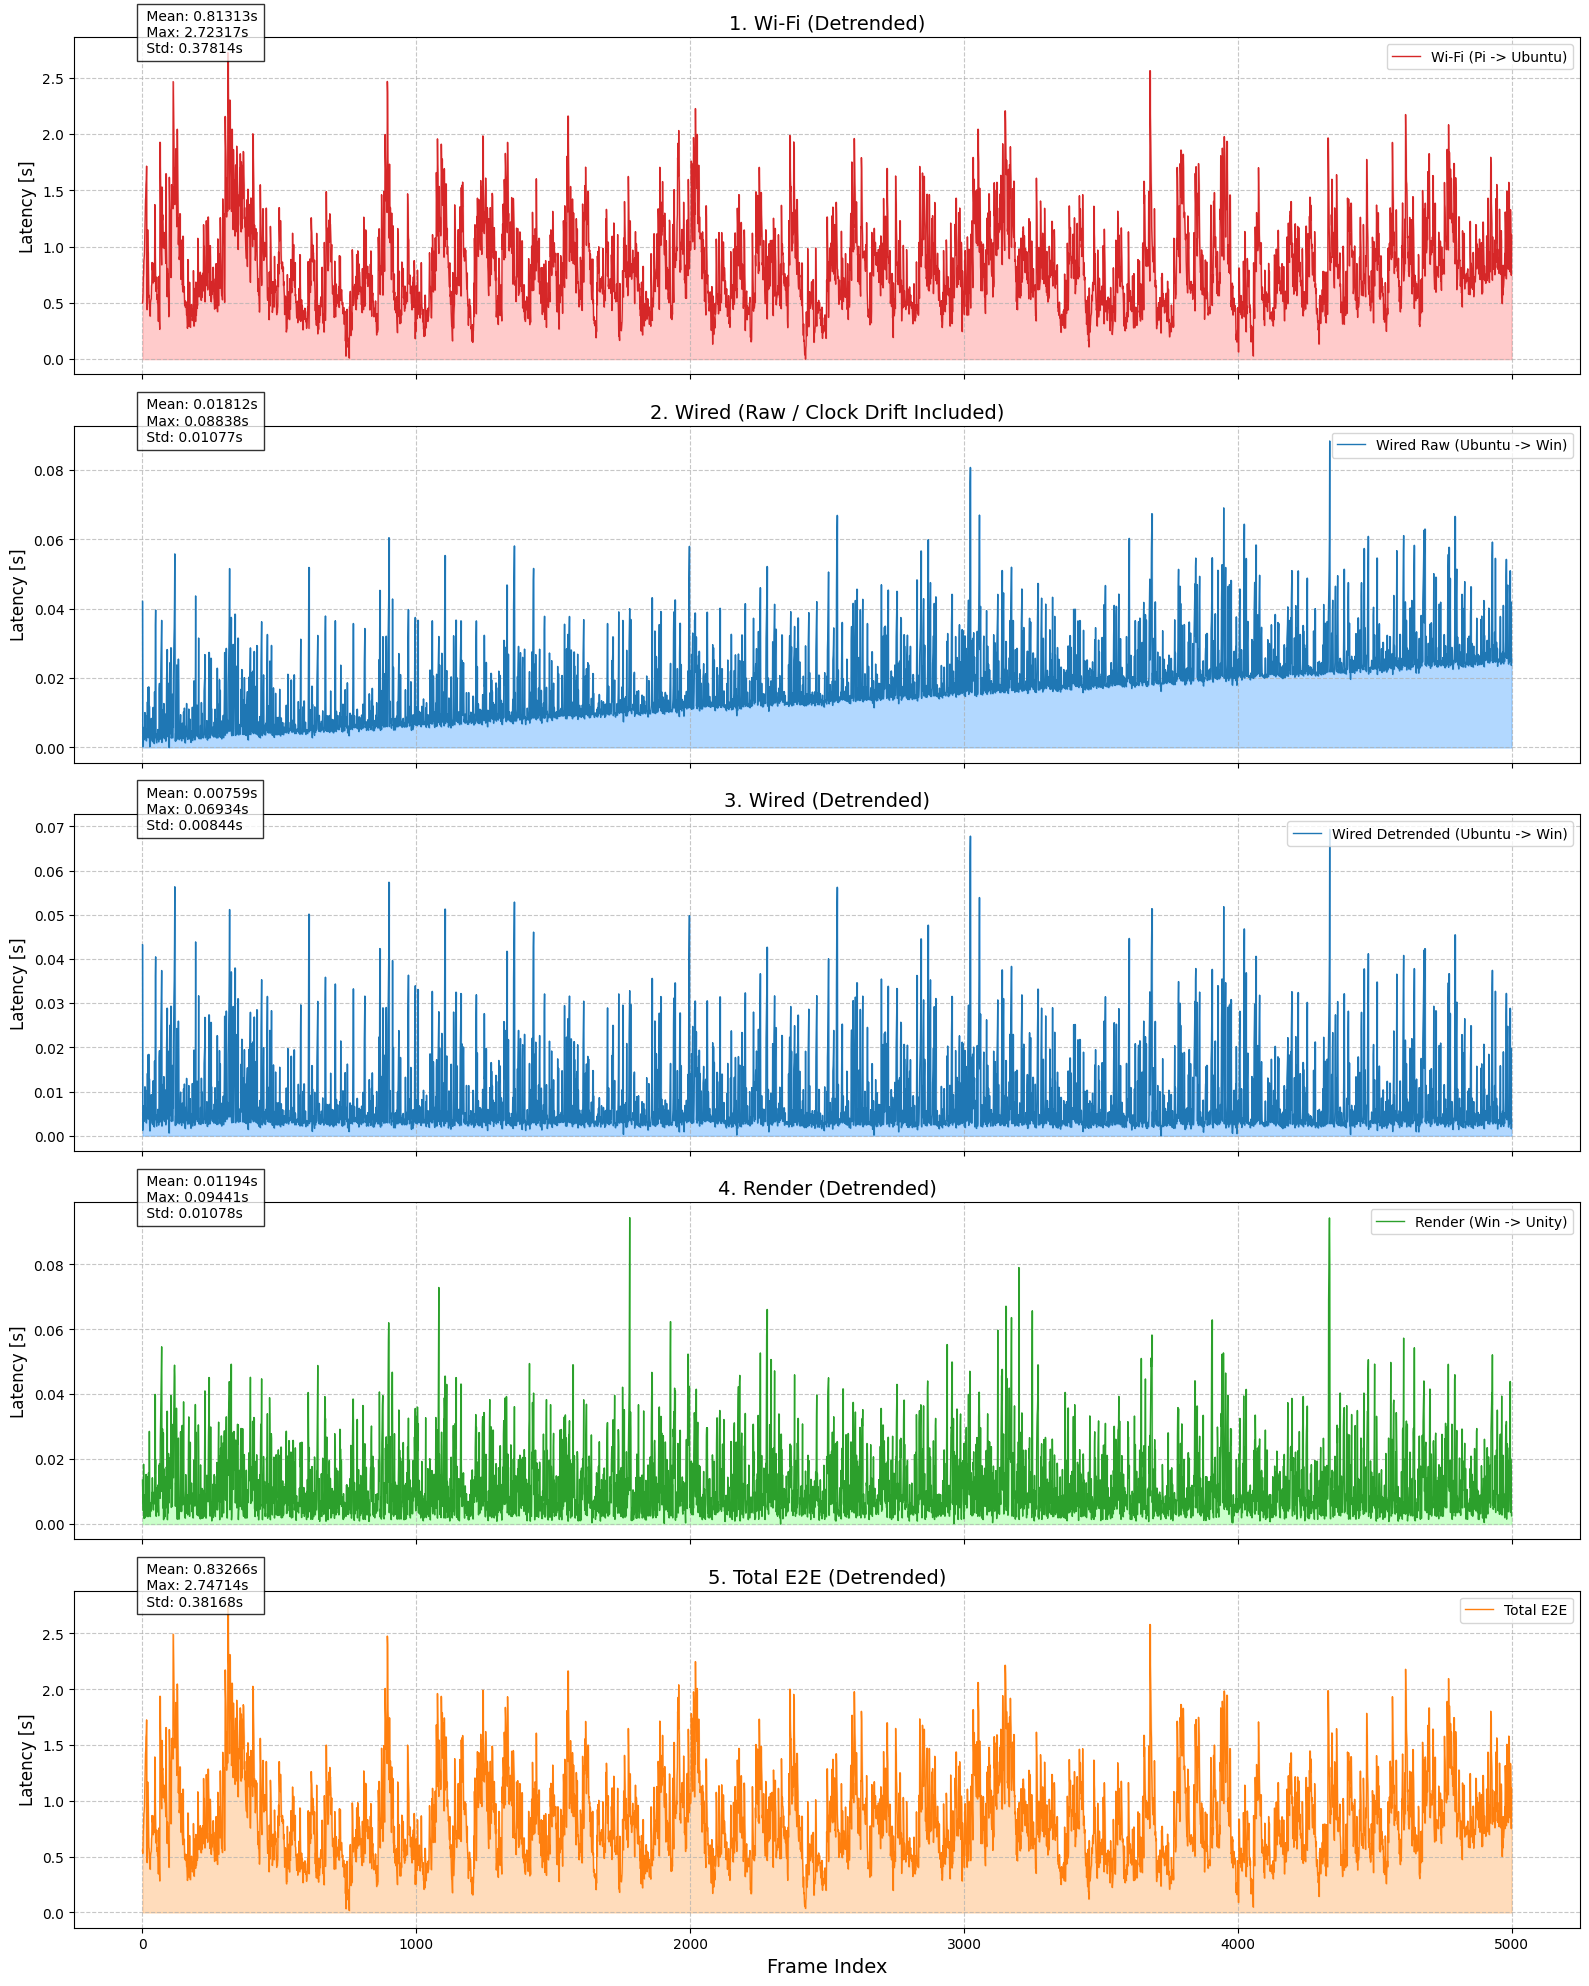

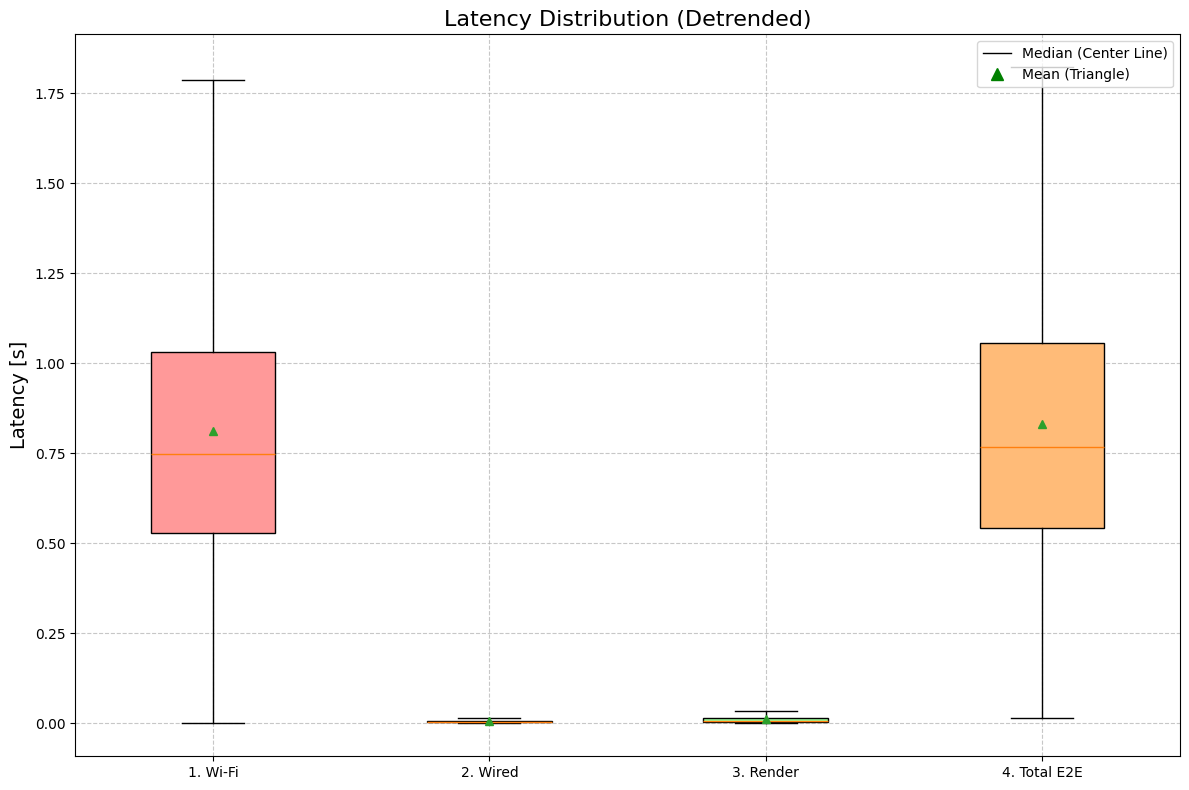

In [3]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal # 科学計算ライブラリを使用

# --- ファイル名 (適宜変更してください) ---
FILE_UBUNTU  = 'ubuntu_e2elog_20251211_154901417.csv'
FILE_WINDOWS = 'unity_udplog_20251211_154903.csv'
FILE_UNITY   = 'unity_e2elog_20251211_154903.csv'

def read_csv(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return list(csv.reader(f))
    except:
        return []

def main():
    # ----------------- ---------------- ----------------
    # ----------------- -- データ読込み - ----------------
    # ----------------- ---------------- ----------------
    u_lines = read_csv(FILE_UBUNTU)
    w_lines = read_csv(FILE_WINDOWS)
    r_lines = read_csv(FILE_UNITY)
    
    if not (u_lines and w_lines and r_lines): return
    min_len = min(len(u_lines), len(w_lines), len(r_lines))
    print(f"Analysis for {min_len} frames...")

    # データ抽出
    t0_list, t1_list, t2_list, t3_list = [], [], [], []

    for i in range(1, min_len):
        try:
            t0_list.append(float(u_lines[i][1]) * 1.0e-9) # LiDAR生成
            t1_list.append(float(u_lines[i][4]))          # Ubuntu受信
            t2_list.append(float(w_lines[i][1]))          # Win受信
            t3_list.append(float(r_lines[i][1]))          # Unity描画
        except:
            continue

    # numpy配列に変換
    np_t0 = np.array(t0_list)
    np_t1 = np.array(t1_list)
    np_t2 = np.array(t2_list)
    np_t3 = np.array(t3_list)

    # ----------------- ---------------- ----------------
    # ----------------- --- 差分計算 ---- ----------------
    # ----------------- ---------------- ----------------
    diff_wifi   = np_t1 - np_t0
    diff_wired  = np_t2 - np_t1
    diff_render = np_t3 - np_t2
    diff_total  = diff_wifi + diff_wired + diff_render

    # --- トレンド除去 (Detrending) ---
    
    # 1. Wi-Fi
    detrend_wifi = signal.detrend(diff_wifi)
    corr_wifi = detrend_wifi - np.min(detrend_wifi)

    # 2. 有線LAN (Raw表示用に、単純に最小値を0にするだけのものも用意)
    wired_raw_shifted = diff_wired - np.min(diff_wired)

    # 3. 有線LAN (Detrended)
    detrend_wired = signal.detrend(diff_wired)
    corr_wired = detrend_wired - np.min(detrend_wired)

    # 4. 描画
    detrend_render = signal.detrend(diff_render)
    corr_render = detrend_render - np.min(detrend_render)

    # 5. 合計E2E (補正済み積み上げ)
    corr_total = corr_wifi + corr_wired + corr_render


    # ----------------- ---------------- ----------------
    # ----------------- --- 時系列グラフ -- ----------------
    # ----------------- ---------------- ----------------
    # 5段のグラフを作成 (有線Rawを追加)
    fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(16, 20), sharex=True)
    indices = np.arange(len(corr_wifi))

    # --- 1. Wi-Fi (赤系) ---
    ax1.plot(indices, corr_wifi, color='#d62728', linewidth=1, label='Wi-Fi (Pi -> Ubuntu)')
    ax1.fill_between(indices, 0, corr_wifi, color='#ff9999', alpha=0.5)
    
    avg_wifi = np.mean(corr_wifi)
    max_wifi = np.max(corr_wifi)
    std_wifi = np.std(corr_wifi)
    ax1.set_title(f'1. Wi-Fi (Detrended)', fontsize=14)
    ax1.set_ylabel('Latency [s]', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right')
    ax1.text(0, max_wifi, f" Mean: {avg_wifi:.5f}s\n Max: {max_wifi:.5f}s\n Std: {std_wifi:.5f}s", bbox=dict(facecolor='white', alpha=0.8))
    print(f"【Wi-Fi】 Avg: {avg_wifi:.5f}s, Max: {max_wifi:.5f}s, Std: {std_wifi:.5f}s")


    # --- 2. 有線LAN Raw (青系・トレンドあり) ---
    # ここは「クロックドリフト」を見せるためのグラフ
    ax2.plot(indices, wired_raw_shifted, color='#1f77b4', linewidth=1, label='Wired Raw (Ubuntu -> Win)')
    ax2.fill_between(indices, 0, wired_raw_shifted, color='#66b3ff', alpha=0.5)

    avg_wired_raw = np.mean(wired_raw_shifted)
    max_wired_raw = np.max(wired_raw_shifted)
    std_wired_raw = np.std(wired_raw_shifted)
    ax2.set_title(f'2. Wired (Raw / Clock Drift Included)', fontsize=14)
    ax2.set_ylabel('Latency [s]', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right')
    ax2.text(0, max_wired_raw, f" Mean: {avg_wired_raw:.5f}s\n Max: {max_wired_raw:.5f}s\n Std: {std_wired_raw:.5f}s", bbox=dict(facecolor='white', alpha=0.8))
    print(f"【Wired Raw】 Avg: {avg_wired_raw:.5f}s, Max: {max_wired_raw:.5f}s, Std: {std_wired_raw:.5f}s")


    # --- 3. 有線LAN Detrended (青系・トレンド除去) ---
    # ここは「真の揺らぎ」を見せるためのグラフ
    ax3.plot(indices, corr_wired, color='#1f77b4', linewidth=1, label='Wired Detrended (Ubuntu -> Win)')
    ax3.fill_between(indices, 0, corr_wired, color='#66b3ff', alpha=0.5)

    avg_wired = np.mean(corr_wired)
    max_wired = np.max(corr_wired)
    std_wired = np.std(corr_wired)
    ax3.set_title(f'3. Wired (Detrended)', fontsize=14)
    ax3.set_ylabel('Latency [s]', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend(loc='upper right')
    ax3.text(0, max_wired, f" Mean: {avg_wired:.5f}s\n Max: {max_wired:.5f}s\n Std: {std_wired:.5f}s", bbox=dict(facecolor='white', alpha=0.8))
    print(f"【Wired Detrended】 Avg: {avg_wired:.5f}s, Max: {max_wired:.5f}s, Std: {std_wired:.5f}s")


    # --- 4. 描画 (緑系) ---
    ax4.plot(indices, corr_render, color='#2ca02c', linewidth=1, label='Render (Win -> Unity)')
    ax4.fill_between(indices, 0, corr_render, color='#99ff99', alpha=0.5)

    avg_render = np.mean(corr_render)
    max_render = np.max(corr_render)
    std_render = np.std(corr_render)
    ax4.set_title(f'4. Render (Detrended)', fontsize=14)
    ax4.set_ylabel('Latency [s]', fontsize=12)
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.legend(loc='upper right')
    ax4.text(0, max_render, f" Mean: {avg_render:.5f}s\n Max: {max_render:.5f}s\n Std: {std_render:.5f}s", bbox=dict(facecolor='white', alpha=0.8))
    print(f"【Render】Avg: {avg_render:.5f}s, Max: {max_render:.5f}s, Std: {std_render:.5f}s")


    # --- 5. 合計 (オレンジ系) ---
    ax5.plot(indices, corr_total, color='#ff7f0e', linewidth=1, label='Total E2E')
    ax5.fill_between(indices, 0, corr_total, color='#ffbb78', alpha=0.5)

    avg_total = np.mean(corr_total)
    max_total = np.max(corr_total)
    std_total = np.std(corr_total)
    ax5.set_title(f'5. Total E2E (Detrended)', fontsize=14)
    ax5.set_ylabel('Latency [s]', fontsize=12)
    ax5.set_xlabel('Frame Index', fontsize=14)
    ax5.grid(True, linestyle='--', alpha=0.7)
    ax5.legend(loc='upper right')
    ax5.text(0, max_total, f" Mean: {avg_total:.5f}s\n Max: {max_total:.5f}s\n Std: {std_total:.5f}s", bbox=dict(facecolor='white', alpha=0.8))
    print(f"【Total】 Avg: {avg_total:.5f}s, Max: {max_total:.5f}s, Std: {std_total:.5f}s")

    plt.tight_layout()
    plt.savefig('latency_timeseries.png')
    print("時系列グラフを保存しました: latency_timeseries.png")


    # ----------------- ---------------- ----------------
    # ----------------- --- 箱ひげ図 ---- ----------------
    # ----------------- ---------------- ----------------
    print("\nGenerating Box Plot...")
    
    # データをリストにまとめる
    data_box = [corr_wifi, corr_wired, corr_render, corr_total]
    labels_box = ['1. Wi-Fi', '2. Wired', '3. Render', '4. Total E2E']
    colors_box = ['#ff9999', '#66b3ff', '#99ff99', '#ffbb78']

    fig2, ax_box = plt.subplots(figsize=(12, 8))
    
    # 箱ひげ図の描画
    bplot = ax_box.boxplot(data_box, labels=labels_box, patch_artist=True, 
                           showmeans=True, showfliers=False)

    # 色付け
    for patch, color in zip(bplot['boxes'], colors_box):
        patch.set_facecolor(color)

    ax_box.set_title('Latency Distribution (Detrended)', fontsize=16)
    ax_box.set_ylabel('Latency [s]', fontsize=14)
    ax_box.grid(True, linestyle='--', alpha=0.7)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=1, label='Median (Center Line)'),
        Line2D([0], [0], marker='^', color='green', label='Mean (Triangle)', markerfacecolor='green', markersize=8, linestyle='None')
    ]
    ax_box.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig('latency_boxplot.png')
    print("箱ひげ図を保存しました: latency_boxplot.png")

    plt.show()

if __name__ == "__main__":
    main()

Analysis for 5001 frames...
【Total】 Avg: 0.83266s, Max: 2.74714s, Std: 0.38168s
時系列グラフを保存しました: latency_timeseries_total.png


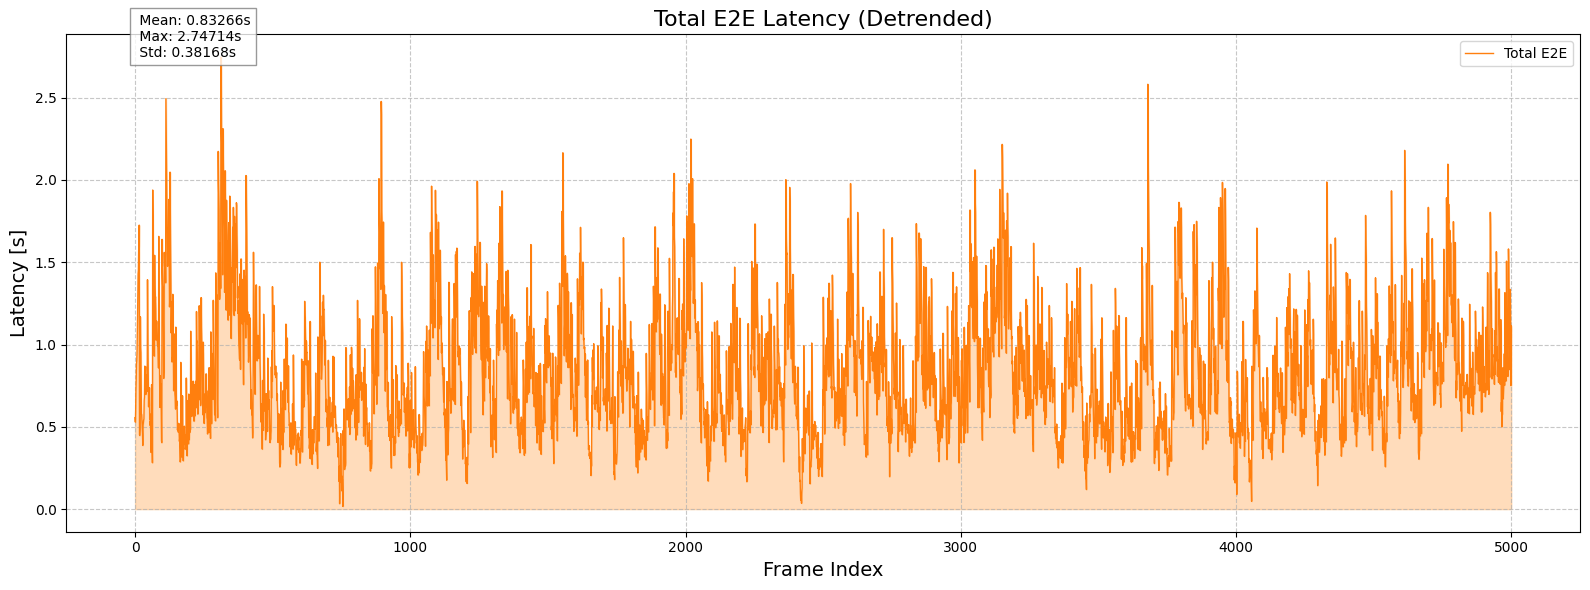

In [4]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal # 科学計算ライブラリを使用

# --- ファイル名 (適宜変更してください) ---
FILE_UBUNTU  = 'ubuntu_e2elog_20251211_154901417.csv'
FILE_WINDOWS = 'unity_udplog_20251211_154903.csv'
FILE_UNITY   = 'unity_e2elog_20251211_154903.csv'

def read_csv(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return list(csv.reader(f))
    except:
        return []

def main():
    # ----------------- ---------------- ----------------
    # ----------------- -- データ読込み - ----------------
    # ----------------- ---------------- ----------------
    u_lines = read_csv(FILE_UBUNTU)
    w_lines = read_csv(FILE_WINDOWS)
    r_lines = read_csv(FILE_UNITY)
    
    if not (u_lines and w_lines and r_lines): return
    min_len = min(len(u_lines), len(w_lines), len(r_lines))
    print(f"Analysis for {min_len} frames...")

    # データ抽出
    t0_list, t1_list, t2_list, t3_list = [], [], [], []

    for i in range(1, min_len):
        try:
            t0_list.append(float(u_lines[i][1]) * 1.0e-9) # LiDAR生成
            t1_list.append(float(u_lines[i][4]))          # Ubuntu受信
            t2_list.append(float(w_lines[i][1]))          # Win受信
            t3_list.append(float(r_lines[i][1]))          # Unity描画
        except:
            continue

    # numpy配列に変換
    np_t0 = np.array(t0_list)
    np_t1 = np.array(t1_list)
    np_t2 = np.array(t2_list)
    np_t3 = np.array(t3_list)

    # ----------------- ---------------- ----------------
    # ----------------- --- 差分計算 ---- ----------------
    # ----------------- ---------------- ----------------
    diff_wifi   = np_t1 - np_t0
    diff_wired  = np_t2 - np_t1
    diff_render = np_t3 - np_t2
    # 合計遅延の計算には、個別のトレンド除去後の値を足し合わせる必要があります

    # --- トレンド除去 (Detrending) ---
    
    # 1. Wi-Fi
    detrend_wifi = signal.detrend(diff_wifi)
    corr_wifi = detrend_wifi - np.min(detrend_wifi)

    # 2. 有線LAN
    detrend_wired = signal.detrend(diff_wired)
    corr_wired = detrend_wired - np.min(detrend_wired)

    # 3. 描画
    detrend_render = signal.detrend(diff_render)
    corr_render = detrend_render - np.min(detrend_render)

    # 4. 合計E2E (補正済み積み上げ)
    corr_total = corr_wifi + corr_wired + corr_render


    # ----------------- ---------------- ----------------
    # ----------------- --- 時系列グラフ -- ----------------
    # ----------------- ---------------- ----------------
    # 1つのグラフを作成
    fig, ax = plt.subplots(figsize=(16, 6)) # 横長で見やすいサイズに設定
    indices = np.arange(len(corr_total))

    # --- 合計 (オレンジ系) ---
    ax.plot(indices, corr_total, color='#ff7f0e', linewidth=1, label='Total E2E')
    ax.fill_between(indices, 0, corr_total, color='#ffbb78', alpha=0.5)

    avg_total = np.mean(corr_total)
    max_total = np.max(corr_total)
    std_total = np.std(corr_total)
    
    # タイトルと軸ラベル
    ax.set_title(f'Total E2E Latency (Detrended)', fontsize=16)
    ax.set_ylabel('Latency [s]', fontsize=14)
    ax.set_xlabel('Frame Index', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')

    # 平均値・最大値をテキスト表示
    ax.text(0, max_total, f" Mean: {avg_total:.5f}s\n Max: {max_total:.5f}s\n Std: {std_total:.5f}s", 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    print(f"【Total】 Avg: {avg_total:.5f}s, Max: {max_total:.5f}s, Std: {std_total:.5f}s")

    plt.tight_layout()
    plt.savefig('latency_timeseries_total.png')
    print("時系列グラフを保存しました: latency_timeseries_total.png")

    plt.show()

if __name__ == "__main__":
    main()

In [5]:
import re

# ==========================================
# 設定: 比較する2つのファイル名
FILE_SENDER   = "traffic_info_20251123_173156_raspberrypi.log"      # 送信元 (ラズパイ)
FILE_RECEIVER = "traffic_info_20251123_173156_ubuntupc.log"  # 受信先 (Ubuntu)
# ==========================================

def parse_log_file(filepath):
    """
    ログファイルを読み込み、(Frame番号, Timeナノ秒) のリストを返す
    """
    data_list = []
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                # 正規表現で Frame番号 と Time を抽出
                # "Frame 1: ... Time: 1763886728211114563 ns" の形式に対応
                match = re.search(r"Frame\s+(\d+).*Time:\s*(\d+)", line)
                if match:
                    frame_num = int(match.group(1))
                    time_ns = int(match.group(2))
                    data_list.append({"frame": frame_num, "time": time_ns, "raw": line.strip()})
    except FileNotFoundError:
        print(f"エラー: ファイル '{filepath}' が見つかりません。")
        return []
    return data_list

def main():
    # 1. データを読み込む
    sender_data = parse_log_file(FILE_SENDER)
    receiver_data = parse_log_file(FILE_RECEIVER)

    if not sender_data or not receiver_data:
        print("比較を中止します。")
        return

    print(f"データ読込完了: 送信元 {len(sender_data)}行, 受信先 {len(receiver_data)}行")
    print("-" * 60)
    print(f"{'Status':<10} | {'Frame (Sender)':<15} | {'Time (ns)':<20}")
    print("-" * 60)

    # 2. 比較ロジック (2ポインタ法)
    i = 0 # 送信元(Sender)のインデックス
    j = 0 # 受信先(Receiver)のインデックス
    
    loss_count = 0
    lost_frames = []

    while i < len(sender_data) and j < len(receiver_data):
        s_item = sender_data[i]
        r_item = receiver_data[j]
        
        # 時刻(Time)で比較する
        if s_item["time"] == r_item["time"]:
            # 一致 -> 正常受信
            # 両方のインデックスを進める
            # print(f"OK         | Frame {s_item['frame']}") # 必要ならコメントアウト解除
            i += 1
            j += 1
        else:
            # 不一致 -> 送信元にあって受信先にない (LOSS)
            # 送信元のデータが欠落しているので、送信元(i)だけ進めて、受信先(j)は待機
            print(f"★ LOSS!    | Frame {s_item['frame']:<14} | {s_item['time']}")
            
            lost_frames.append(s_item)
            loss_count += 1
            i += 1

    # 3. 末尾の残存データチェック
    # 受信側のデータが尽きたのに、送信側にまだデータが残っている場合、それらは全てロス
    while i < len(sender_data):
        s_item = sender_data[i]
        print(f"★ LOSS!    | Frame {s_item['frame']:<14} | {s_item['time']} (End of Stream)")
        lost_frames.append(s_item)
        loss_count += 1
        i += 1

    print("-" * 60)
    print(f"\n【解析結果】")
    print(f"パケットロス総数: {loss_count} 個")
    print(f"ロス率: {(loss_count / len(sender_data)) * 100:.2f} %")

if __name__ == "__main__":
    main()

データ読込完了: 送信元 5000行, 受信先 5000行
------------------------------------------------------------
Status     | Frame (Sender)  | Time (ns)           
------------------------------------------------------------
★ LOSS!    | Frame 2314           | 1763887078611507458
★ LOSS!    | Frame 4629           | 1763887427813013319
------------------------------------------------------------

【解析結果】
パケットロス総数: 2 個
ロス率: 0.04 %
